### Robust classification
- classification performance with different training data
> original <br>
> original + ctf_by_human <br>
> original + ctf_by_auto_generated <br>
- classification performance with different number of causal words being substitued <br>
> Performance of only substitute causal words <br>
> Performance of substituting all top terms <br>

In [3]:
import io, time
from itertools import combinations, cycle, product
from IPython.display import display

import nltk
import numpy as np
import pandas as pd
import pickle, random, re
from collections import Counter
from PyDictionary import PyDictionary
dictionary=PyDictionary()

from tqdm.notebook import tqdm
pd.set_option('max_colwidth', -1) # change None to -1

import sklearn

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

random.seed(42)

In [6]:
from Generate_counterfactual import run_counterfactual
from Classification import get_top_terms
data_path = 'my_data_path'   

In [7]:
class Counterfactual:
    def __init__(self, df_train, df_test, moniker):
        display(df_train.head(1))
        self.moniker = moniker
        self.train = df_train
        self.test = df_test
        
def load_data(moniker):
    if(moniker == 'kindle'):
        ds = pickle.load(open(data_path+"kindle_ct/ds_kindle.pkl", "rb"))
    elif(moniker == 'imdb'):
        ds = pickle.load(open(data_path+"imdb_ct/ds_imdb.pkl", "rb"))
    elif(moniker == 'imdb_sents'):
        ds = pickle.load(open(data_path+"imdb_ct/split_sents/ds_imdb.pkl", "rb"))
    
    return ds

In [22]:
def organize_data(ds, limit=''):
    """
    Organize data for easy use in the evaluation
    'original','original+ctf_by_predicted_causal','original+ctf_by_annotated_causal','original+ctf_by_all_causal','original+ctf_by_human'
    
    """
    train_data = {}
    if(limit == 'ct'): # only those have counterfactuals as original data
        ds.train['len_ct_text_causal'] = ds.train['ct_text_causal'].apply(lambda x: len(x.strip()))
        df_select = ds.train[ds.train['len_ct_text_causal'] > 0]
        train_data['original'] = {'text':df_select.text.values, 'label':df_select.label.values}
    else:
        train_data['original'] = {'text':ds.train.text.values, 'label':ds.train.label.values}
    
    if(ds.moniker == 'imdb'):
        train_data['ctf_by_human'] = {'text':ds.train.ct_text_amt.values, 'label':ds.train.ct_label.values}
        train_data['original+ctf_by_human'] = {'text':list(train_data['original']['text'])+list(ds.train.ct_text_amt.values), 
                                          'label':list(train_data['original']['label'])+list(ds.train.ct_label.values)}
    
    elif(ds.moniker == 'imdb_sents'):
        train_data['ctf_by_human'] = {'text':ds.train_ct.text.values, 'label':ds.train_ct.label.values}
        train_data['original+ctf_by_human'] = {'text':list(train_data['original']['text'])+list(ds.train_ct.text.values), 
                                          'label':list(train_data['original']['label'])+list(ds.train_ct.label.values)}
        
    for flag, col in zip(['predicted_causal','annotated_causal','all_causal'],['identified_causal','causal','all_causal']):
        ds.train['len_ct_text_'+col] = ds.train['ct_text_'+col].apply(lambda x: len(x.strip()))
        df_train_ct_text_flag = ds.train[ds.train['len_ct_text_'+col] > 0]
        train_data['ctf_'+flag] = {'text':df_train_ct_text_flag['ct_text_'+col].values, 'label':df_train_ct_text_flag.ct_label.values}
        train_data['original+ctf_by_'+flag] = {'text':list(train_data['original']['text'])+list(df_train_ct_text_flag['ct_text_'+col].values), 
                                          'label':list(train_data['original']['label'])+list(df_train_ct_text_flag.ct_label.values)}

    
    test_data = {}
    ds.test['len_ct_text_causal'] = ds.test['ct_text_causal'].apply(lambda x: len(x.strip()))
    df_test_ct_text_causal = ds.test[ds.test.len_ct_text_causal > 0]
    
    test_data['Original'] = {'text': ds.test.text.values, 'label': ds.test.label.values}
    test_data['ct_causal'] = {'text': df_test_ct_text_causal.ct_text_causal.values, 'label': df_test_ct_text_causal.ct_label.values}
    
    
    if(ds.moniker == 'imdb_sents'):
        test_data['Counterfactual'] = {'text': ds.test_ct.text.values, 'label': ds.test_ct.label.values}
    else:
        test_data['Counterfactual'] = {'text': ds.test.ct_text_amt.values, 'label': ds.test.ct_label.values}
        
    if(ds.moniker == 'kindle'):
        test_data['original_selected'] = {'text': ds.select_test.text.values, 'label': ds.select_test.label.values}
        test_data['ct_amt_selected'] = {'text': ds.select_test.ct_text_amt.values, 'label': ds.select_test.ct_label.values}
    
    return train_data, test_data

#### Classification performance with different training data

In [25]:
def fit_classifier(train_text, train_label, test_text, test_label, report=True, train='comb'):
    """
    Given training data and test data
    """
    if(len(train_text) == 0 or len(test_text) == 0): # not generating any counterfactual examples
        return 0.0
    
    vec = CountVectorizer(min_df=5, binary=True, max_df=.8)
    if(train == 'comb'):
        X = vec.fit_transform(list(train_text) + list(test_text))
        X_train = vec.transform(train_text)
        X_test = vec.transform(test_text)
    elif(train == 'train'):
        X_train = vec.fit_transform(list(train_text))
        X_test = vec.transform(test_text)
    
    clf = LogisticRegression(class_weight='auto', solver='lbfgs', max_iter=1000)
    clf.fit(X_train, train_label)
    
    
    if(report):
        print(classification_report(test_label, clf.predict(X_test)))
        return clf, vec
    else:
        result = classification_report(test_label, clf.predict(X_test), output_dict=True)
        return float('%.3f' % result['accuracy'])

In [42]:
def classification_performance(train_data, test_data):
    """
    train: original, ct_auto, original+ct_auto
    test: original, ct_auto, ct_amt
    ct_text_auto: if no causal words or no antonym substitutions, then not use it;
    Not every text could generate a counterfactual text;
    """
    
    df_result = pd.DataFrame({'Sample_size':[0]*5,
                              'Original':[0]*5,
                              'Counterfactual':[0]*5})
    
    df_result.rename(index={i: f for i, f in enumerate(['original','original+ctf_by_predicted_causal','original+ctf_by_annotated_causal','original+ctf_by_all_causal','original+ctf_by_human'])}, inplace=True)

        
    for train_flag, test_flag in product(['original','original+ctf_by_predicted_causal','original+ctf_by_annotated_causal','original+ctf_by_all_causal','original+ctf_by_human'],['Original','Counterfactual']):
        try:
            df_result.loc[train_flag,'Sample_size'] = len(train_data[train_flag]['label'])
            df_result.loc[train_flag,test_flag] = fit_classifier(train_data[train_flag]['text'], 
                                                                 train_data[train_flag]['label'],
                                                                 test_data[test_flag]['text'], 
                                                                 test_data[test_flag]['label'], report=False)
        except: # no human annotated counterfactual training data for kindle  
            df_result.loc[train_flag,'Sample_size'] = np.NaN
            df_result.loc[train_flag,test_flag] = np.NaN
    
    return df_result

- Robust classification for IMDB-L

In [27]:
ds = load_data('imdb')
train_data, test_data = organize_data(ds,limit='')
df_result = classification_performance(train_data, test_data)
df_result

,Sample_size,Original,Counterfactual
original,1707,0.816,0.615
original+ctf_by_predicted_causal,2991,0.742,0.744
original+ctf_by_annotated_causal,3325,0.760,0.818
original+ctf_by_all_causal,3401,0.773,0.857
original+ctf_by_human,3414,0.818,0.869


- Robust classification for IMDB-S

In [28]:
ds = load_data('imdb_sents')
train_data, test_data = organize_data(ds,limit='')
df_result = classification_performance(train_data, test_data)
df_result

,Sample_size,Original,Counterfactual
original,8173,0.711,0.605
original+ctf_by_predicted_causal,10744,0.685,0.660
original+ctf_by_annotated_causal,11828,0.679,0.696
original+ctf_by_all_causal,16202,0.685,0.726
original+ctf_by_human,16679,0.705,0.762


- Robust classification for Kindle

In [43]:
ds = load_data('kindle')
train_data, test_data = organize_data(ds,limit='')
df_result = classification_performance(train_data, test_data)
df_result

,Sample_size,Original,Counterfactual
original,10000.0,0.888,0.514
original+ctf_by_predicted_causal,15725.0,0.866,0.624
original+ctf_by_annotated_causal,15695.0,0.882,0.662
original+ctf_by_all_causal,19954.0,0.752,0.720
original+ctf_by_human,NaN,NaN,NaN


#### Performance change with different number of causal word substitutions

In [428]:
def substitute_causal_terms(data_path,ds,train_data,test_data,moniker,df_causal_terms,flag):
    """
    n_causal: number of causal words being substituted
    How does the performance change with different number of causal word being substituted?
    """
    
    # re-generate counterfactuals for p% causal terms from topn causal
    run_counterfactual(data_path,ds,df_causal_terms,moniker,flag,show_data=False)
    train_data, test_data = organize_data(ds)
    
    df_result = classification_performance(train_data, test_data)
    
    # count the number of augmented counterfactual training samples
    ds.train['len_ct_text_'+flag] = ds.train['ct_text_'+flag].apply(lambda x: len(x.strip()))
    n_train = ds.train[ds.train['len_ct_text_'+flag] > 0].shape[0]
    
    ds.test['len_ct_text_'+flag] = ds.test['ct_text_'+flag].apply(lambda x: len(x.strip()))
    n_test = ds.test[ds.test['len_ct_text_'+flag] > 0].shape[0]
    
    substitute_result = {}
    for f in ['original','ct_causal','ctf']:
        substitute_result[f] = df_result.loc['original+ct_'+flag,f]
    
    return n_train, n_test, substitute_result

In [443]:
def performance_of_causal_substitution(data_path,ds,train_data,test_data):
    """
    Performance change with different number of causal substitutions
    # sort terms in abs(coef) descending order
    """
    causal_substitution = []

    # range for all causal terms
    ds.all_causal_terms['coef_abs'] = ds.all_causal_terms['coef'].apply(lambda x: abs(x))
    ds.all_causal_terms = ds.all_causal_terms.sort_values(by=['coef_abs'],ascending=False)
    
    for n in list(np.arange(0, ds.all_causal_terms.shape[0], 10))+[ds.all_causal_terms.shape[0]]:
        if( n% 50 == 0):
            print(n)
        df_causal_terms = ds.all_causal_terms.head(n)
        flag = 'all_causal'
        
        
        # run to get result
        n_train, n_test, substitute_result = substitute_causal_terms(data_path,ds,train_data,test_data,ds.moniker,
                                                                     df_causal_terms,flag)
        
        causal_substitution.append({'substitute_causal_wds': n,
                                    'flag':flag,
                                    'n_train_ctf':n_train,
                                    'n_test_ctf':n_test,
                                    'original':substitute_result['original'],
                                    'Counterfactual':substitute_result['ctf']})

    return pd.DataFrame(causal_substitution)

In [26]:
def plot_result(causal_substitution_result, moniker):
    
    x_values = causal_substitution_result.substitute_causal_wds.values[:-2]
    ticks = plt.xticks(ticks=range(len(x_values)), labels=x_values)
    plt.title('Performance change with counterfactually augmented data \n from different number of causal word substitutions (%s)' % moniker)
    plt.xlabel('Causal word substitutions')
    plt.ylabel('Test set accuracy')

    plt.plot(range(len(x_values)), causal_substitution_result.ct_amt.values[:-2], 'o-', label='ct_amt')
    plt.legend()

In [21]:
def select_sentence_bywd(ds, wd, limit='no_causal'):
    """
    Select sentences contain a word
    """
    wd_docs = []
    for ri, row in ds.train.iterrows():
        if(wd in row['causal_wds']):
            if(limit == 'no_causal'):
                flag = 0
                for s_wd in row['causal_wds']:
                    if(s_wd in ds.top_terms[ds.top_terms.causal == 1].term.values):
                        flag = 1
                        
                if(flag == 0):
                    wd_docs.append(ri)
            else:
                wd_docs.append(ri)
                
    df_wd = ds.train.loc[wd_docs]
    
    return df_wd

- Kindle 

In [444]:
ds = load_data(moniker='kindle')
train_data, test_data = organize_data(ds,limit='')
start = time.time()
causal_substitution_result_kindle = performance_of_causal_substitution(data_path,ds,train_data,test_data)
end = time.time()
print((end-start)/60)

0
50
100
150
200
250
21.048294870058694


- IMDB-L

In [447]:
ds = load_data(moniker='imdb')
train_data, test_data = organize_data(ds,limit='')
start = time.time()
causal_substitution_result_imdb = performance_of_causal_substitution(data_path,ds,train_data,test_data)
end = time.time()
print((end-start)/60)

0
50
100
150
200
250
23.847073352336885


- IMDB-S

In [449]:
ds = load_data(moniker='imdb_sents')
train_data, test_data = organize_data(ds,limit='')
start = time.time()
causal_substitution_result_imdb_sents = performance_of_causal_substitution(data_path,ds,train_data,test_data)
end = time.time()
print((end-start)/60)

0
50
100
150
200
250
21.45292599995931


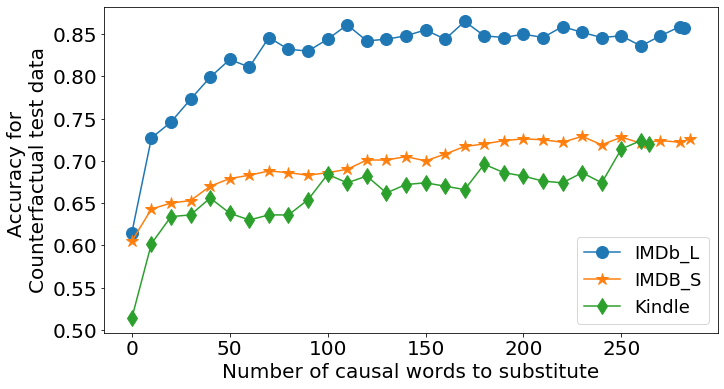

In [513]:
fig = plt.figure(figsize=(11,6))
for causal_substitution_result, moniker,m in zip([causal_substitution_result_imdb, causal_substitution_result_imdb_sents, causal_substitution_result_kindle],['IMDb_L','IMDB_S','Kindle'],['o','*','d']):
    x_values = causal_substitution_result.substitute_causal_wds.values
    plt.plot(x_values, causal_substitution_result.ct_amt.values, label=moniker, markersize=12, marker=m)
    
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
    
plt.xlabel('Number of causal words to substitute', fontsize=20)
plt.ylabel('Accuracy for \nCounterfactual test data', fontsize=20)
plt.legend(loc='lower right', fontsize=18)
# fig.savefig('./Fig/classifier_causalFromVocab.png')

In [461]:
causal_substitution_result_imdb.head()

,substitute_causal_wds,flag,n_train_ct,n_test_ct,original,ct_causal,ct_amt
0,0,all_causal,0,0,0.816,0.301,0.615
1,10,all_causal,898,260,0.748,0.521,0.727
2,20,all_causal,1085,297,0.764,0.554,0.746
3,30,all_causal,1264,343,0.750,0.622,0.773
4,40,all_causal,1454,405,0.750,0.666,0.799


In [25]:
ds.top_terms[ds.top_terms.causal == 1]

,term,coef,causal,antonyms,n_antonyms,antonym_source
83,adorable,1.187,1,{'ugly': -0.681},1,antonym
142,amazing,1.124,1,"{'unimpressive': -0.462, 'ugly': -0.681, 'ineffective': -1.062}",3,synonym_antonym
174,annoying,-1.043,1,{'good': 1.191},1,synonym_antonym
204,appropriate,1.496,1,{'inappropriate': -0.311},1,antonym
269,awesome,1.321,1,{'unimpressive': -0.462},1,antonym
...,...,...,...,...,...,...
3464,wasted,-1.371,1,{'found': 0.198},1,antonym
3465,wasting,-1.040,1,"{'good': 1.191, 'strength': 0.357}",2,synonym_antonym
3552,wonderful,2.007,1,"{'unimpressive': -0.462, 'inferior': -0.644}",2,antonym
3568,worse,-1.839,1,"{'better': 0.257, 'best': 1.267}",2,antonym
